## **1) Problem Tanımı**

 * Problem : Yemeksepeti kullanıcılarının yaptığı yorumlara dayanarak yemeklerin beğenilip beğenilmediğini otomatik olarak tespit etmek.

#### **Alt Problemler**

* Kullanıcı yorumlarının işlenmesi ve temizlenmesi.
* Yorumlardaki olumlu ve olumsuz ifadelerin doğru şekilde sınıflandırılması.
* Yemeklerin genel değerlendirme puanları ile yorumların ilişkilendirilmesi.

#### **Kim(ler) için Problem**

* Restoranlar: Yemeklerinin kullanıcılar tarafından nasıl algılandığını anlamak.
* Yemeksepeti kullanıcıları: Diğer kullanıcıların yorumlarını analiz ederek yemek seçimi yapmak.
* Platform Yöneticileri: Genel müşteri memnuniyetini artırmak için hizmet kalitesini optimize etmek.

#### **Etkisi** 

* Restoranların menülerini iyileştirmelerine yardımcı olur.
* Kullanıcıların daha bilinçli karar vermesini sağlar.
* Yemeksepeti platformunun kullanıcı deneyimini geliştirir.



------

## **2) Hedef Ölçüm Metodu**

#### **Hedefler**

* Yemeklerin kullanıcı yorumlarına dayanarak %80+ doğruluk oranıyla beğenilip beğenilmediğini sınıflandırmak.
* Yorumlardaki anahtar ifadeleri belirlemek (örneğin, "çok lezzetli", "hızlı servis").

#### **Ölçüm Metotları**

##### -Başarı Metrikleri

* Accuracy, Precision, Recall, F1 Score.
* Confusion Matrix ile sınıflandırma performansının görselleştirilmesi.

#### - Neden Bu Metotlar ? 

* Accuracy, genel doğruluğu ölçmek için.
* Precision ve Recall, olumlu/olumsuz sınıflandırmadaki dengesizliği anlamak için.

_________

## **3) Çözüm Yöntemi**

#### **1 - Raw Data(Ham Veri)**

* Yemeksepeti yorumlarını içeren veri seti (60k yorum).
* Sütunlar: review, flavour, service, speed.

#### **2 - Text Preprocessing (Metin Ön İşleme)**

* Yorumların temizlenmesi:
* Küçük harfe dönüştürme.
* Noktalama işaretlerini kaldırma.
* Türkçe stopwords temizleme.
* Türkçe karakterleri İngilizce'ye dönüştürme.

#### **3 - Feature (Özellik) Engineering**

* TF-IDF kullanılarak yorumların sayısal temsillerinin oluşturulması.

* TF-IDF (Term Frequency-Inverse Document Frequency), metin verilerindeki kelimelerin önemini belirlemek için kullanılan bir yöntemdir. Bu yöntem, bir kelimenin bir belgede ne sıklıkla geçtiğini (TF) ve bu kelimenin tüm belgelerde ne kadar özel olduğunu (IDF) hesaba katarak bir ağırlık hesaplar.

#### - Kısaca 
* TF (Term Frequency) : Kelimenin metnimizde kaç defa tekrar ettiği
* IDF (Inverse Document Frequency): Kelimenin tüm belgelerdeki yaygınlığı. Yaygın kelimeler düşük ağırlık alır.

* Sonunda her yorumumuz kelimelerin ağırlığına göre sayısal değerler alır sayısal vektörlere dönüştürülmüş olur

#### **4- Model Training**

* Eğitim ve test setlerine bölme. (train-test-split işlemi)
* Logistic Regression, SVM gibi modellerin eğitilmesi.

#### **5 - Evaluation (Değerlendirme)**

* Model performansının doğruluk ve diğer metriklerle değerlendirilmesi.

___

____

## **4) Kod**

#### **0- Gerekli Kütüphaneleri Ekleme**

In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE  

ModuleNotFoundError: No module named 'nltk'

#### **1- Veri Yükleme, İnceleme ve Temizlik**

In [2]:

# CSV dosyasını yükle
df = pd.read_csv('c:/Users/kerak/OneDrive/Masaüstü/yorumsepeti/yorumsepeti.csv', sep=';')


# Eksik verileri kontrol et
print("Eksik veriler:\n", df.isnull().sum())

# Boş değerleri NaN ile değiştirme
df.replace('-', np.nan, inplace=True)

# Eksik 'review' değerlerini kaldır
df.dropna(subset=['review'], inplace=True)

# Geçersiz değerleri temizleme ve sayısal hale getirme
for col in ['flavour', 'service', 'speed']:
    df[col] = pd.to_numeric(df[col], errors='coerce')
    df[col] = df[col].fillna(df[col].mean())

# 2. Metin Temizleme

def clean_text(text):
    if isinstance(text, str):
        text = text.lower()  # Küçük harfe çevir
        text = re.sub(r'[^\w\s]', '', text)  # Noktalama işaretlerini kaldır
        stop_words = set(stopwords.words('turkish'))  # Türkçe stopwords
        text = ' '.join([word for word in text.split() if word not in stop_words])  # Stopwords'leri kaldır
        
        # Türkçe karakterleri İngilizce karakterlere dönüştür
        translation_table = str.maketrans("şğüöçıİŞĞÜÖÇ", "sguociISGUOC")
        text = text.translate(translation_table)
        
    return text

# Yorumları temizle
df['cleaned_review'] = df['review'].apply(clean_text)

print("Temizlenmiş yorumlar:")
print(df['cleaned_review'].head(10))

# 3. Duygu Etiketi Oluşturma

def label_sentiment(row):
    if row['flavour'] > 5:
        return 'Olumlu'
    elif row['flavour'] <= 5 or row['service'] <= 5:
        return 'Olumsuz'
    else:
        return 'Olumsuz'  # Nötr sınıfını sonuçları etkilediği için kaldırdık

df['true_sentiment'] = df.apply(label_sentiment, axis=1)

# Sınıf dağılımını kontrol et
print("\nSınıf Dağılımı:\n", df['true_sentiment'].value_counts())


Eksik veriler:
 speed       0
service     0
flavour     0
review     33
dtype: int64
Temizlenmiş yorumlar:
0    zaman komsu firindan siparis verdigim eksik go...
1    sosisli urun isteyen adama peynirli bisey yoll...
2    siparisimi cok hizli getiren ekip arkadasiniza...
3    after waiting more tjan one hour they didnt de...
4    iyi pissin soylememe ragmen pismis geldi birda...
5    kokmus hamburger getirdiniz be ayip ulan resme...
6    yiyecegi ozenle getiriyolar lezzeti oldukca iy...
7    allah affetsin kotuydu bir mi iyi olmaz be kar...
8                                       tavsiye ederim
9                         durum bozukdu kotu kokuyordu
Name: cleaned_review, dtype: object

Sınıf Dağılımı:
 true_sentiment
Olumlu     49765
Olumsuz    10444
Name: count, dtype: int64


#### **2- Feature(Özellik) Mühendisliği**

In [3]:
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2)) 
X = tfidf.fit_transform(df['cleaned_review'])
y = df['true_sentiment']

#### 3- **Verileri Bölme ve Modellerimizin Eğitimi**

In [4]:
# Veri Setini Eğitim ve Test Olarak Bölme
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Modellerin Eğitimi

# 3.1 Logistic Regression

logistic_model = LogisticRegression(max_iter=1000, random_state=42)
logistic_model.fit(X_train, y_train)
y_pred_logistic = logistic_model.predict(X_test)
accuracy_logistic = accuracy_score(y_test, y_pred_logistic)
print(f"\nLogistic Regression Doğruluğu: {accuracy_logistic:.2f}")
print("\nLogistic Regression Classification Report:\n", classification_report(y_test, y_pred_logistic, target_names=['Olumsuz', 'Olumlu']))


# 3.2 SVM ( Support Vector Machine )

svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print(f"SVM Doğruluğu: {accuracy_svm:.2f}")
print("\nSVM Classification Report:\n", classification_report(y_test, y_pred_svm, target_names=['Olumsuz', 'Olumlu']))


# 3.3 Random Forest      süreyi çok uzatıyor ve accuracy 0.90 civarında

# rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
# rf_model.fit(X_train, y_train)
# y_pred_rf = rf_model.predict(X_test)
# accuracy_rf = accuracy_score(y_test, y_pred_rf)
# print(f"Random Forest Doğruluğu: {accuracy_rf:.2f}")
# print("\nRandom Forest Classification Report:\n", classification_report(y_test, y_pred_rf, target_names=['Olumsuz', 'Olumlu']))






Logistic Regression Doğruluğu: 0.91

Logistic Regression Classification Report:
               precision    recall  f1-score   support

     Olumsuz       0.93      0.97      0.95      9953
      Olumlu       0.80      0.64      0.71      2089

    accuracy                           0.91     12042
   macro avg       0.87      0.80      0.83     12042
weighted avg       0.91      0.91      0.91     12042

SVM Doğruluğu: 0.91

SVM Classification Report:
               precision    recall  f1-score   support

     Olumsuz       0.93      0.96      0.95      9953
      Olumlu       0.77      0.68      0.72      2089

    accuracy                           0.91     12042
   macro avg       0.85      0.82      0.83     12042
weighted avg       0.91      0.91      0.91     12042



#### **4- Değerlendirme**

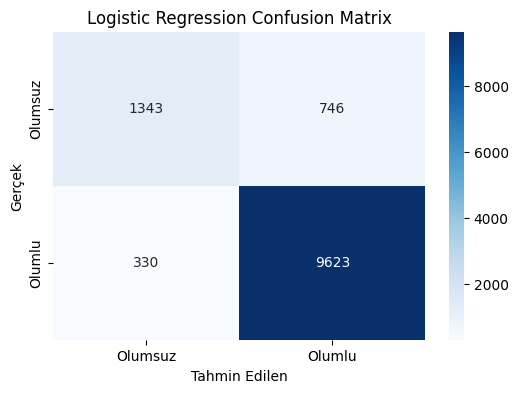

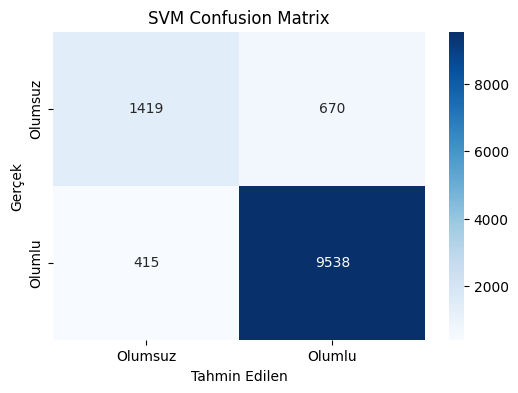

Logistic Regression 5-Fold Cross-Validation Doğruluk Skorları: [0.91222388 0.91413386 0.90699219 0.90649394 0.90864546]
Logistic Regression Ortalama Doğruluk: 0.91

SVM 5-Fold Cross-Validation Doğruluk Skorları: [0.91164258 0.91454908 0.90823783 0.90749045 0.90980816]
SVM Ortalama Doğruluk: 0.91

En İyi Logistic Regression Parametreleri: {'C': 1, 'solver': 'lbfgs'}
En İyi Logistic Regression Doğruluk: 0.91
Optimizasyon Sonrası Logistic Regression Doğruluğu: 0.91

Optimized Logistic Regression Classification Report:
               precision    recall  f1-score   support

     Olumsuz       0.93      0.97      0.95      9953
      Olumlu       0.80      0.64      0.71      2089

    accuracy                           0.91     12042
   macro avg       0.87      0.80      0.83     12042
weighted avg       0.91      0.91      0.91     12042



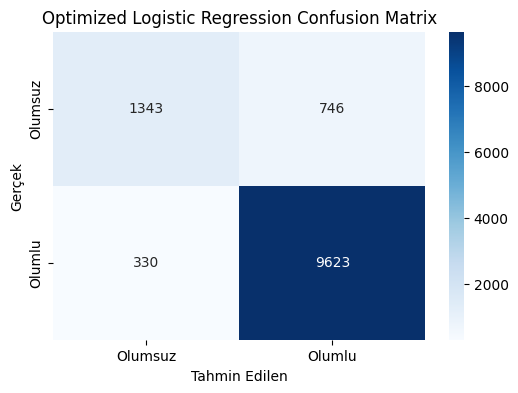

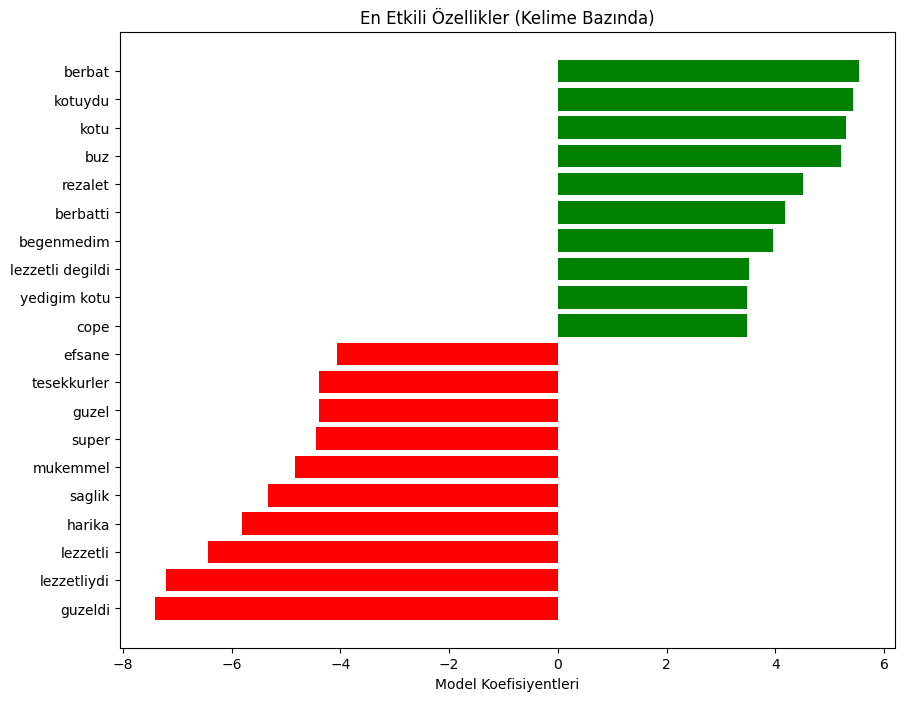

C:\Users\kerak\AppData\Local\Temp\ipykernel_17012\4226588631.py:77: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models, y=accuracies, palette='viridis')


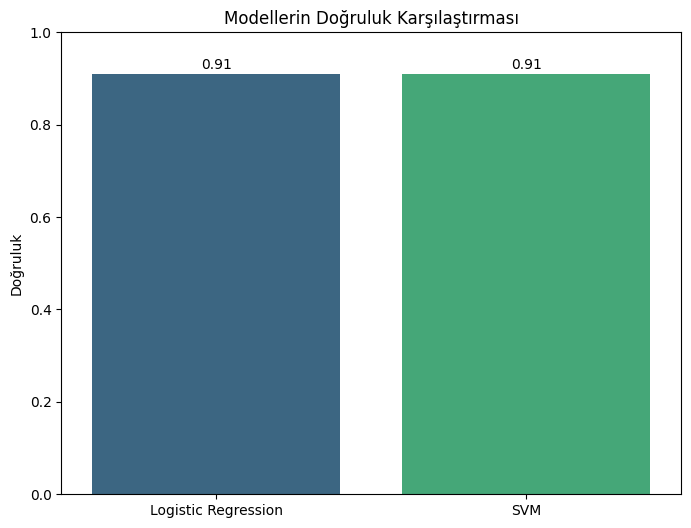

In [6]:
# 8. Confusion Matrix Görselleştirme

def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred, labels=['Olumsuz', 'Olumlu'])
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Olumsuz', 'Olumlu'], yticklabels=['Olumsuz', 'Olumlu'])
    plt.xlabel('Tahmin Edilen')
    plt.ylabel('Gerçek')
    plt.title(f'{model_name} Confusion Matrix')
    plt.show()

# Confusion Matrix'leri çiz
plot_confusion_matrix(y_test, y_pred_logistic, 'Logistic Regression')
plot_confusion_matrix(y_test, y_pred_svm, 'SVM')
#* plot_confusion_matrix(y_test, y_pred_rf, 'Random Forest')

# 9. Çapraz Doğrulama ile Model Performansını Değerlendirme

def cross_validate_model(model, X, y, model_name):
    cv_scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
    print(f"{model_name} 5-Fold Cross-Validation Doğruluk Skorları: {cv_scores}")
    print(f"{model_name} Ortalama Doğruluk: {cv_scores.mean():.2f}\n")

cross_validate_model(logistic_model, X, y, 'Logistic Regression')
cross_validate_model(svm_model, X, y, 'SVM')
#* cross_validate_model(rf_model, X, y, 'Random Forest')

# 10. Hiperparametre Optimizasyonu

# Örneğin, Logistic Regression için Grid Search
param_grid_logistic = {
    'C': [0.1, 1, 10, 100],
    'solver': ['liblinear', 'lbfgs']
}

grid_logistic = GridSearchCV(LogisticRegression(max_iter=1000, random_state=42), param_grid_logistic, cv=5, scoring='accuracy', n_jobs=-1)
grid_logistic.fit(X_train, y_train)

print(f"En İyi Logistic Regression Parametreleri: {grid_logistic.best_params_}")
print(f"En İyi Logistic Regression Doğruluk: {grid_logistic.best_score_:.2f}")

# En iyi modeli kullanarak tahmin yap
best_logistic = grid_logistic.best_estimator_
y_pred_best_logistic = best_logistic.predict(X_test)
accuracy_best_logistic = accuracy_score(y_test, y_pred_best_logistic)
print(f"Optimizasyon Sonrası Logistic Regression Doğruluğu: {accuracy_best_logistic:.2f}")
print("\nOptimized Logistic Regression Classification Report:\n", classification_report(y_test, y_pred_best_logistic, target_names=['Olumsuz', 'Olumlu']))

# Optimize lojistik regresyon için confusion matrix
plot_confusion_matrix(y_test, y_pred_best_logistic, 'Optimized Logistic Regression')

# 11. En İyi Özelliklerin İncelenmesi (Logistic Regression)

feature_names = tfidf.get_feature_names_out()
coefficients = best_logistic.coef_[0]

# En olumlu ve en olumsuz etkili kelimeler
top_positive_coefficients = np.argsort(coefficients)[-10:]
top_negative_coefficients = np.argsort(coefficients)[:10]
top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])

plt.figure(figsize=(10, 8))
plt.barh(range(len(top_coefficients)), coefficients[top_coefficients], align='center', color=['red']*10 + ['green']*10)
plt.yticks(range(len(top_coefficients)), feature_names[top_coefficients])
plt.xlabel('Model Koefisiyentleri')
plt.title('En Etkili Özellikler (Kelime Bazında)')
plt.show()

# 12. Model Karşılaştırması
# ---------------------------
# models = ['Logistic Regression', 'SVM', 'Random Forest']
# accuracies = [accuracy_logistic, accuracy_svm, accuracy_rf]
models  = ['Logistic Regression', 'SVM']
accuracies = [accuracy_logistic, accuracy_svm]

plt.figure(figsize=(8,6))
sns.barplot(x=models, y=accuracies, palette='viridis')
plt.ylim(0,1)
plt.title('Modellerin Doğruluk Karşılaştırması')
plt.ylabel('Doğruluk')
for index, value in enumerate(accuracies):
    plt.text(index, value + 0.01, f"{value:.2f}", ha='center')
plt.show()

In [16]:

my_comment = "YEmeğinizin tuzu yoktu"

cleancomment = clean_text(my_comment)

print(f"{cleancomment}\n")

predicted_sentiment = best_logistic.predict(tfidf.transform([cleancomment]))

print("tahmin edlien sonuc...:", predicted_sentiment[0])

yemeginizin tuzu yoktu

tahmin edlien sonuc...: Olumsuz
